In [226]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [227]:
companies = pd.read_csv("companies.csv",engine="python")

In [228]:
# Find number of unique companies

companies['permalink'].unique().size

66368

In [229]:
rounds2 = pd.read_csv("rounds2.csv",engine="python")

In [230]:
rounds2['company_permalink'] = rounds2['company_permalink'].apply(lambda x: x.lower())

In [231]:
# Find number of unique companies in rounds

rounds2['company_permalink'].unique().size

66368

In [232]:
#Convert to lower case so that it doesnt treat same row differently

companies['permalink'] = companies['permalink'].apply(lambda x: x.lower())

In [233]:
#Merge the companies and rounds2 table based on the company_permlink and permlink

master_frame = rounds2.merge(companies,how="inner",left_on="company_permalink",right_on="permalink")
master_frame = master_frame.drop(["permalink"],axis=1)
master_frame.shape

(114949, 15)

In [234]:
#Find the percentage of null values in each column
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink           0.00
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         72.91
funded_at                   0.00
raised_amount_usd          17.39
name                        0.00
homepage_url                5.34
category_list               2.97
status                      0.00
country_code                7.55
state_code                  9.52
region                      8.84
city                        8.84
founded_at                 17.85
dtype: float64

In [235]:
# Drop all columns which are not required for analysus
master_frame = master_frame.drop(["funding_round_permalink","funding_round_code","funded_at","status","state_code","region","city","founded_at"],axis=1)
master_frame.head()

,company_permalink,funding_round_type,raised_amount_usd,name,homepage_url,category_list,country_code
0,/organization/-fame,venture,10000000.0,#fame,http://livfame.com,Media,IND
1,/organization/-qounter,venture,NaN,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,USA
2,/organization/-qounter,seed,700000.0,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,USA
3,/organization/-the-one-of-them-inc-,venture,3406878.0,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,NaN
4,/organization/0-6-com,venture,2000000.0,0-6.com,http://www.0-6.com,Curated Web,CHN


##### As Spark is only interested in venture/seed/angle/private equity so filter out all other rows

In [236]:
master_frame = master_frame[(master_frame['funding_round_type'] == 'venture') | (master_frame['funding_round_type'] == 'seed') | (master_frame['funding_round_type'] == 'angel') | (master_frame['funding_round_type'] == 'private_equity') ]

### Find missing values

In [237]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink      0.00
funding_round_type     0.00
raised_amount_usd     14.59
name                   0.00
homepage_url           4.39
category_list          2.65
country_code           7.76
dtype: float64

 ##### When columns raised_amount_usd and country_code both are  empty then that row will not provide any input to us for further analysis. So removing them

In [238]:
master_frame = master_frame[ ~((pd.isnull(master_frame['raised_amount_usd'])) & (pd.isnull(master_frame['country_code']))) ]

In [239]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink      0.00
funding_round_type     0.00
raised_amount_usd     12.45
name                   0.00
homepage_url           4.02
category_list          1.65
country_code           5.45
dtype: float64

In [240]:
master_frame["raised_amount_usd"].describe()

count    8.062700e+04
mean     9.347995e+06
std      7.562940e+07
min      0.000000e+00
25%      4.000000e+05
50%      2.000000e+06
75%      7.975496e+06
max      1.760000e+10
Name: raised_amount_usd, dtype: float64

C:\Users\Supran\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


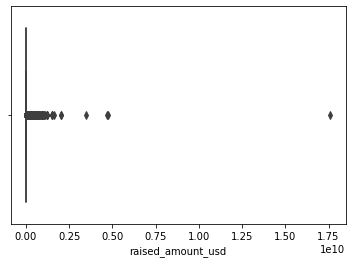

In [241]:
sns.boxplot(master_frame['raised_amount_usd'])
plt.show()

#### As there are outliers so using median to find most representetive value for each funding type

In [242]:
res = master_frame.groupby(['funding_round_type'])['raised_amount_usd'].agg(pd.Series.median)
res

funding_round_type
angel               400000.0
private_equity    20000000.0
seed                275000.0
venture            5000000.0
Name: raised_amount_usd, dtype: float64

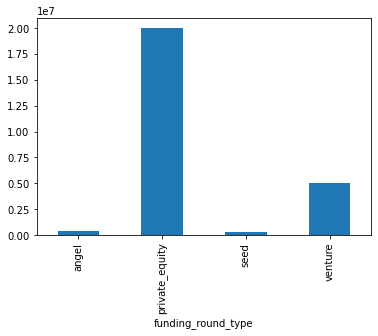

In [243]:

res.plot.bar()
plt.show()


### Above plot and result shows that only venture type is within 5-15 million so we need to ony keep those rows which are of venture

In [244]:
master_frame = master_frame[master_frame['funding_round_type'] == 'venture']

In [245]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink     0.00
funding_round_type    0.00
raised_amount_usd     8.24
name                  0.00
homepage_url          5.03
category_list         1.45
country_code          3.87
dtype: float64

## As country is categorical value so imputing it with mode of the column

In [246]:
mode_country = master_frame["country_code"].mode()
print(mode_country[0])

USA


In [247]:
master_frame["country_code"] = master_frame["country_code"].fillna(mode_country[0])

In [248]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink     0.00
funding_round_type    0.00
raised_amount_usd     8.24
name                  0.00
homepage_url          5.03
category_list         1.45
country_code          0.00
dtype: float64

### Filter rows which are above 15 million USD or less than 5 million usd as they are not applicable for spark in analysis

In [249]:
master_frame = master_frame[(master_frame["raised_amount_usd"] >= 5000000) & (master_frame["raised_amount_usd"] <= 15000000)]

In [250]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink     0.00
funding_round_type    0.00
raised_amount_usd     0.00
name                  0.00
homepage_url          5.37
category_list         1.20
country_code          0.00
dtype: float64

## sort raised_amount_usd in decreasing order by country based on total amount

In [251]:
result = pd.pivot_table(data=master_frame,values=['raised_amount_usd'], index=['country_code'], aggfunc=np.sum ).sort_values(by=['raised_amount_usd'], ascending=False).head(9)

In [252]:
result.head()

,raised_amount_usd
country_code,
USA,1.147119e+11
GBR,5.436844e+09
CHN,5.016561e+09
CAN,3.647010e+09
IND,2.976544e+09


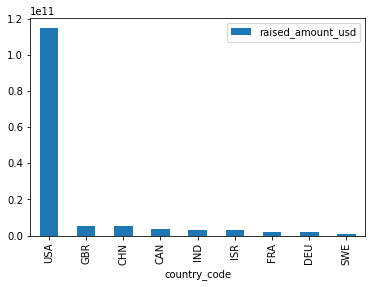

In [253]:
result.plot.bar()
plt.show()

## sort raised_amount_usd in decreasing order by country based on number of investment

In [254]:
result = pd.pivot_table(data=master_frame,values=['raised_amount_usd'], index=['country_code'], aggfunc='count' ).sort_values(by=['raised_amount_usd'], ascending=False).head(9)

In [255]:
result.head()

,raised_amount_usd
country_code,
USA,12853
GBR,628
CHN,533
CAN,426
IND,330


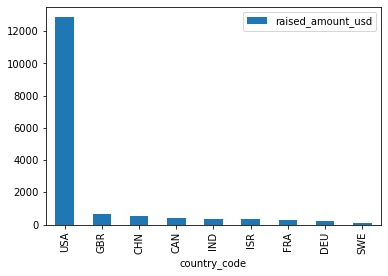

In [256]:

result.plot.bar()
plt.show()

#### Refering to this link https://en.wikipedia.org/wiki/List_of_countries_and_territories_where_English_is_an_official_language so top 3 countries where english is official language will be USA , GBR and CAN

In [257]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink     0.00
funding_round_type    0.00
raised_amount_usd     0.00
name                  0.00
homepage_url          5.37
category_list         1.20
country_code          0.00
dtype: float64

## As only 2% of rows where category_list are empty we see very less impact if we remove it , so we will filter it out for further analysis on sector

In [258]:
master_frame = master_frame[~pd.isnull(master_frame['category_list'])]

In [259]:
mapping = pd.read_csv('mapping.csv',engine="python")
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [260]:
mapping = mapping[~pd.isnull(mapping["category_list"])]

In [261]:
#Removing the blank columns
mapping = mapping.drop(["Blanks"],axis=1)

In [262]:
mapping.head()

,category_list,Automotive & Sports,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
1,3D,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,1,0,0,0,0


### Convert wide table to long table

In [263]:
value_vars = list(mapping.columns[1:])

id_vars = list(np.setdiff1d(mapping.columns, value_vars))

print(value_vars, "\n")
print(id_vars)

['Automotive & Sports', 'Cleantech / Semiconductors', 'Entertainment', 'Health', 'Manufacturing', 'News, Search and Messaging', 'Others', 'Social, Finance, Analytics, Advertising'] 

['category_list']


In [264]:
long_mapping = pd.melt(mapping, 
        id_vars = id_vars, 
        value_vars = value_vars)

long_mapping

,category_list,variable,value
0,3D,Automotive & Sports,0
1,3D Printing,Automotive & Sports,0
2,3D Technology,Automotive & Sports,0
3,Accounting,Automotive & Sports,0
4,Active Lifestyle,Automotive & Sports,0
...,...,...,...
5491,Wholesale,"Social, Finance, Analytics, Advertising",0
5492,Wine And Spirits,"Social, Finance, Analytics, Advertising",0
5493,Wireless,"Social, Finance, Analytics, Advertising",0
5494,Women,"Social, Finance, Analytics, Advertising",0


In [265]:
# remove rows having value=0
long_mapping = long_mapping[long_mapping['value']==1]
long_mapping = long_mapping.drop('value', axis=1)

In [266]:
long_mapping = long_mapping.rename(columns={'variable':'main_sector'})

In [267]:
long_mapping["category_list"].value_counts()

Commercial Real Estate    1
Legal                     1
Productivity              1
Property Ma0gement        1
Startups                  1
                         ..
Customer Service          1
Public Relations          1
A0lytics                  1
Agriculture               1
Technology                1
Name: category_list, Length: 687, dtype: int64

In [268]:
long_mapping.head()

,category_list,main_sector
7,Adventure Travel,Automotive & Sports
13,Aerospace,Automotive & Sports
44,Auto,Automotive & Sports
45,Automated Kiosk,Automotive & Sports
46,Automotive,Automotive & Sports


In [269]:
master_frame['category_list'] = master_frame['category_list'].apply(lambda x: x.split('|')[0])

In [270]:
master_frame = master_frame.merge(long_mapping,on="category_list")

In [271]:
master_frame["main_sector"].value_counts()

Others                                     3971
Cleantech / Semiconductors                 3071
Social, Finance, Analytics, Advertising    2507
News, Search and Messaging                 2165
Health                                     1177
Manufacturing                              1124
Entertainment                               941
Automotive & Sports                         259
Name: main_sector, dtype: int64

### Filter master frame with only top 3 countries required for our analysis

In [272]:
master_frame = master_frame[ (master_frame["country_code"] == 'USA') |  (master_frame["country_code"] == 'GBR') |  (master_frame["country_code"] == 'CAN')]

###  Plot a chart to show the comparison of different sector in top 3 countries based on number of investement

main_sector
Others                                     3063
Cleantech / Semiconductors                 2387
Social, Finance, Analytics, Advertising    2008
News, Search and Messaging                 1664
Health                                      959
Manufacturing                               857
Entertainment                               630
Automotive & Sports                         183
Name: raised_amount_usd, dtype: int64


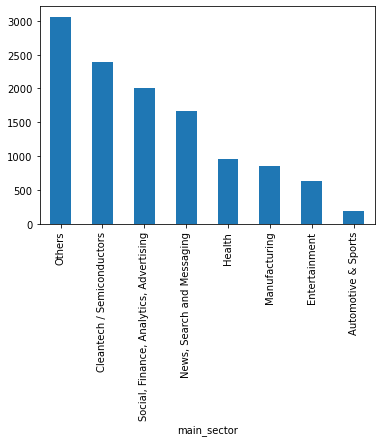

main_sector
Others                                     2.722281e+10
Cleantech / Semiconductors                 2.198866e+10
Social, Finance, Analytics, Advertising    1.754635e+10
News, Search and Messaging                 1.471255e+10
Health                                     8.644301e+09
Manufacturing                              7.801044e+09
Entertainment                              5.449170e+09
Automotive & Sports                        1.591336e+09
Name: raised_amount_usd, dtype: float64


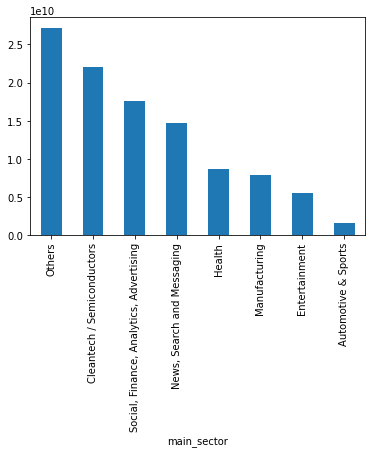

In [273]:
result = master_frame[master_frame["country_code"] == 'USA'].groupby(["main_sector"])["raised_amount_usd"].count().sort_values(ascending=False)
print(result)
result.plot.bar()
plt.show()

result = master_frame[master_frame["country_code"] == 'USA'].groupby(["main_sector"])["raised_amount_usd"].sum().sort_values(ascending=False)
print(result)
result.plot.bar()
plt.show()


main_sector
Others                                     143
Cleantech / Semiconductors                 127
Social, Finance, Analytics, Advertising     98
News, Search and Messaging                  73
Entertainment                               54
Manufacturing                               42
Health                                      24
Automotive & Sports                         16
Name: raised_amount_usd, dtype: int64


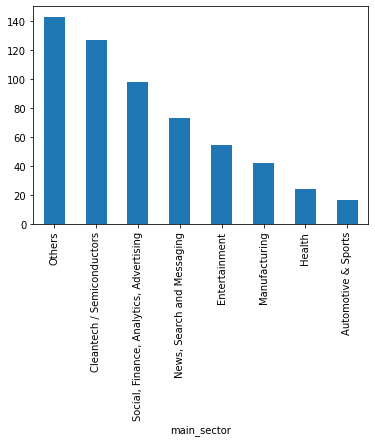

main_sector
Others                                     1.249124e+09
Cleantech / Semiconductors                 1.136905e+09
Social, Finance, Analytics, Advertising    8.218884e+08
News, Search and Messaging                 6.157462e+08
Entertainment                              4.615111e+08
Manufacturing                              3.619403e+08
Health                                     2.145375e+08
Automotive & Sports                        1.670516e+08
Name: raised_amount_usd, dtype: float64


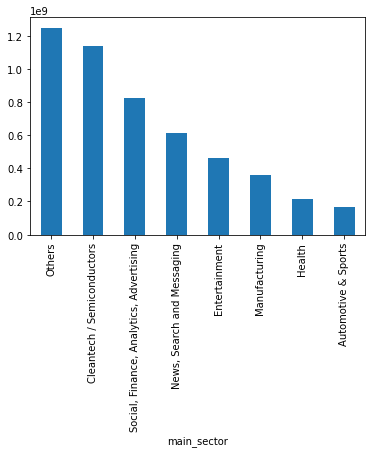

In [274]:
result = master_frame[master_frame["country_code"] == 'GBR'].groupby(["main_sector"])["raised_amount_usd"].count().sort_values(ascending=False)
print(result)
result.plot.bar()
plt.show()

result = master_frame[master_frame["country_code"] == 'GBR'].groupby(["main_sector"])["raised_amount_usd"].sum().sort_values(ascending=False)
print(result)
result.plot.bar()
plt.show()


main_sector
Cleantech / Semiconductors                 112
Others                                     109
Social, Finance, Analytics, Advertising     52
News, Search and Messaging                  46
Manufacturing                               31
Entertainment                               22
Health                                      20
Automotive & Sports                          2
Name: raised_amount_usd, dtype: int64


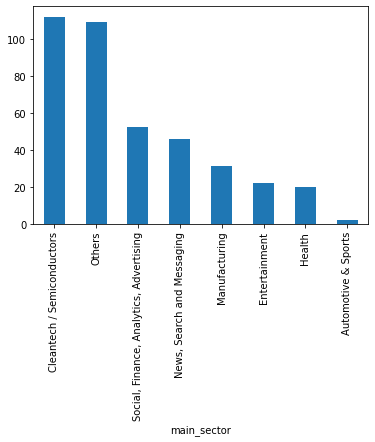

main_sector
Cleantech / Semiconductors                 1.015888e+09
Others                                     9.261380e+08
Social, Finance, Analytics, Advertising    4.433431e+08
News, Search and Messaging                 4.201211e+08
Manufacturing                              2.376331e+08
Health                                     1.621451e+08
Entertainment                              1.540221e+08
Automotive & Sports                        1.500000e+07
Name: raised_amount_usd, dtype: float64


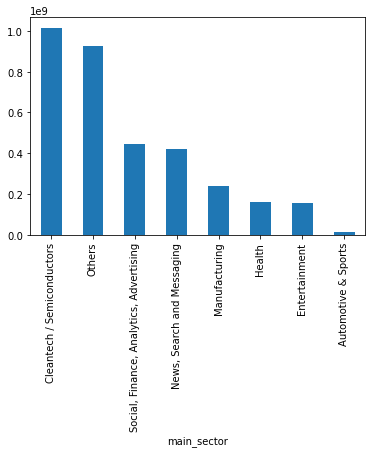

In [275]:
result = master_frame[master_frame["country_code"] == 'CAN'].groupby(["main_sector"])["raised_amount_usd"].count().sort_values(ascending=False)
print(result)
result.plot.bar()
plt.show()

result = master_frame[master_frame["country_code"] == 'CAN'].groupby(["main_sector"])["raised_amount_usd"].sum().sort_values(ascending=False)
print(result)
result.plot.bar()
plt.show()

<AxesSubplot:xlabel='country_code'>

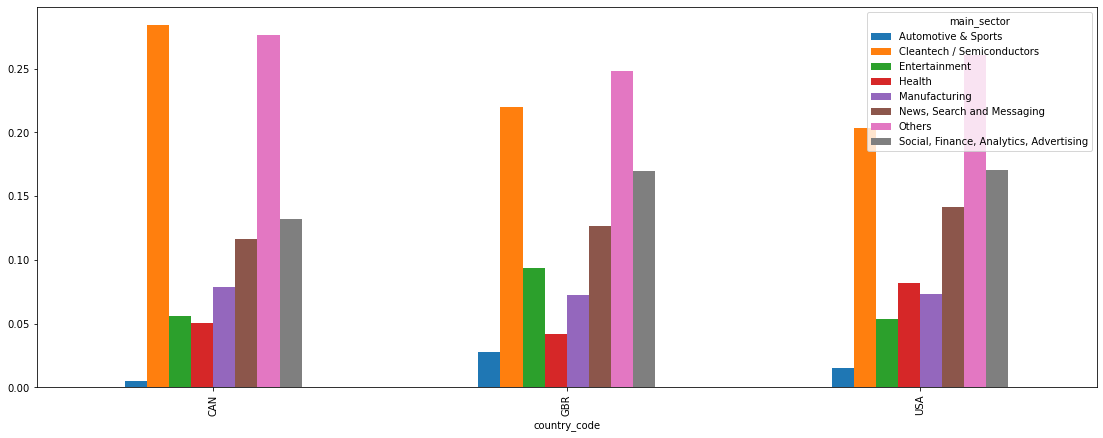

In [276]:
 
result = pd.crosstab(index=master_frame["country_code"] , columns=master_frame["main_sector"], values=master_frame["raised_amount_usd"],aggfunc='count',normalize="index")
result.plot.bar(figsize=(19,7))


### Amount invested in each company in USA across Other category

In [277]:
master_frame[(master_frame["country_code"] == "USA") & (master_frame["main_sector"] == "Others")].groupby(["name"])["raised_amount_usd"].sum().sort_values(ascending=False)

name
Virtustream            64300000.0
Capella Photonics      54968051.0
AirTight Networks      54201907.0
deCarta                52100000.0
Black Duck Software    51000000.0
                          ...    
PeakStream              5000000.0
Peak8 Partners          5000000.0
TrustYou                5000000.0
Tuition.io              5000000.0
Lore                    5000000.0
Name: raised_amount_usd, Length: 2153, dtype: float64

### Amount invested in each company in USA across Cleantech / Semiconductors category

In [278]:
master_frame[(master_frame["country_code"] == "USA") & (master_frame["main_sector"] == "Cleantech / Semiconductors")].groupby(["name"])["raised_amount_usd"].sum().sort_values(ascending=False)

name
Biodesix                        75300000.0
Tigo Energy                     68739496.0
ForSight Labs                   61300001.0
Rheonix                         56124758.0
SCIenergy                       55375423.0
                                   ...    
CorNova                          5000000.0
InCarda Therapeutics             5000000.0
Impedance Cardiology Systems     5000000.0
ORBITAL SYSTEMS                  5000000.0
Spinal Restoration               5000000.0
Name: raised_amount_usd, Length: 1656, dtype: float64

### Amount invested in each company in GBR across Other category

In [279]:
master_frame[(master_frame["country_code"] == "GBR") & (master_frame["main_sector"] == "Others")].groupby(["name"])["raised_amount_usd"].sum().sort_values(ascending=False)

name
Electric Cloud             37000000.0
SenSage                    36250000.0
Enigmatec                  32500000.0
SilverRail Technologies    29000000.0
OpenCloud                  27972766.0
                              ...    
Bacula Systems              5000000.0
Vector Watch                5000000.0
BullGuard                   5000000.0
PhotoBox                    5000000.0
Udex                        5000000.0
Name: raised_amount_usd, Length: 117, dtype: float64

### Amount invested in each company in GBR across Cleantech / Semiconductors category

In [280]:
master_frame[(master_frame["country_code"] == "GBR") & (master_frame["main_sector"] == "Cleantech / Semiconductors")].groupby(["name"])["raised_amount_usd"].sum().sort_values(ascending=False)

name
EUSA Pharma                     35600000.0
Horizon Discovery               31353719.0
F-star Biotechnology Limited    29132906.0
Elixent                         25000000.0
Takeda Cambridge                22340000.0
                                   ...    
Lamellar Biomedical              5301059.0
MMIC Solutions                   5250000.0
Flowline                         5104587.0
Ignis Energy                     5014644.0
Exco InTouch                     5000000.0
Name: raised_amount_usd, Length: 104, dtype: float64

### Amount invested in each company in CAN across Cleantech / Semiconductors category

In [281]:
master_frame[(master_frame["country_code"] == "CAN") & (master_frame["main_sector"] == "Cleantech / Semiconductors")].groupby(["name"])["raised_amount_usd"].sum().sort_values(ascending=False)

name
Fresco Microchip            48000000.0
Ostara                      43152682.0
Diablo Technologies         35500000.0
Zymeworks                   34100000.0
enGene                      31150000.0
                               ...    
CRAiLAR                      5090068.0
CelluFuel                    5000000.0
MedGenesis Therapeutix       5000000.0
Smart Energy Instruments     5000000.0
UTILICASE                    5000000.0
Name: raised_amount_usd, Length: 80, dtype: float64

### Amount invested in each company in CAN across Others category

In [282]:
master_frame[(master_frame["country_code"] == "CAN") & (master_frame["main_sector"] == "Others")].groupby(["name"])["raised_amount_usd"].sum().sort_values(ascending=False)

name
QuickPlay Media         38700000.0
NewStep Networks        31477853.0
Strangeloop Networks    21500000.0
Morega Systems          20000000.0
LxDATA                  19310000.0
                           ...    
Bistro Corp              5000000.0
Hatsize                  5000000.0
Tungle.me                5000000.0
Aimetis                  5000000.0
TeamBuy                  5000000.0
Name: raised_amount_usd, Length: 88, dtype: float64